# Lesson: Bayesian Linear Regression

You will learn about:

1. Exploring the data -- and why it matters
    - What do the data look like?
    - Which natural processes could generate them?
    - A simple, non-Bayesian linear regression
2. How everything fits together
    - Prior
    - Prior predictive
    - Posterior
    - Posterior predictive
    - Incrementally improving a model
3. Out-of-sample predictions
    - Making predictions with new, unobserved data
    - Doing it with PyMC3

In [1]:
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

When I lived in Lyon, I liked to go to the market on Sundays. There, you could find all the fruits, vegetables, meat or cheese you wanted. Interestingly though, there were no fish. I'm not versed enough in the mechanics of markets to really know why, but now that I think about it, the fish market is always something of its own in France -- it's not mixed with the other products (my prior? It's because of the smell).

Whatever the reason, I think it's high time we give a little more attention to fish markets!

## Exploratory data analysis

As it happens, there is an interesting open-source dataset [available online](https://www.kaggle.com/aungpyaeap/fish-market), with records of seven common different fish species in fish market sales -- their weight, length, height, width.

First, this dataset is a testimony to the fact that one can really find _anything_ on the internet -- if one ever doubted it. Second, it will allow us to explore linear regression and out-of-sample predictions, while getting familiar with ArviZ and PyMC. Let's dive in (pun intended)!

In [3]:
fish_market = pd.read_csv("data/fish-market.csv")
fish_market

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


In [4]:
fish_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


For each observation, we have the fish's species, weight, height, width and not one, not two, but three (!) different length measurements. We have 159 measurements and all the columns have the appropriate data type.

We don't have any missing data, but we do have some fish with weight zero -- either the fish was too small for the scale to notice it, or there was a mistake somehow during data collection. Finally, let's note that the standard deviation in the data is very high, especially for weights.

In [5]:
fish_market.describe().round(2)

,Weight,Length1,Length2,Length3,Height,Width
count,159.00,159.00,159.00,159.00,159.00,159.00
mean,398.33,26.25,28.42,31.23,8.97,4.42
std,357.98,10.00,10.72,11.61,4.29,1.69
min,0.00,7.50,8.40,8.80,1.73,1.05
25%,120.00,19.05,21.00,23.15,5.94,3.39
50%,273.00,25.20,27.30,29.40,7.79,4.25
75%,650.00,32.70,35.50,39.65,12.37,5.58
max,1650.00,59.00,63.40,68.00,18.96,8.14


It feels a bit weird to have three columns for length. These are probably very correlated with one another. Let's check this:

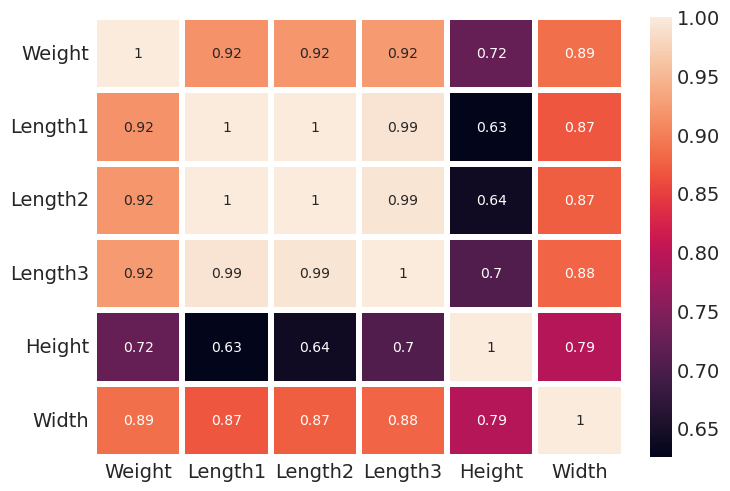

In [6]:
sns.heatmap(fish_market.corr(), annot=True, linewidths=4);

Bingo: the three length measurements are very correlated, so, without more information about their differences, we should just arbitrarily drop two of them, as they provide virtually the same information:

In [7]:
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")

### Section recap

- Exploring your data is a very important first step of the modeling workflow
- It gives you insights in the data generating process
- Pay attention especially to missing data and highly correlated variables
- Ask yourself: which story will my model tell?

## Visual exploratory analysis

Now is a good time to look at how the different measurements relate to each other:

/Users/alex_andorra/opt/anaconda3/envs/intuitive_bayes/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


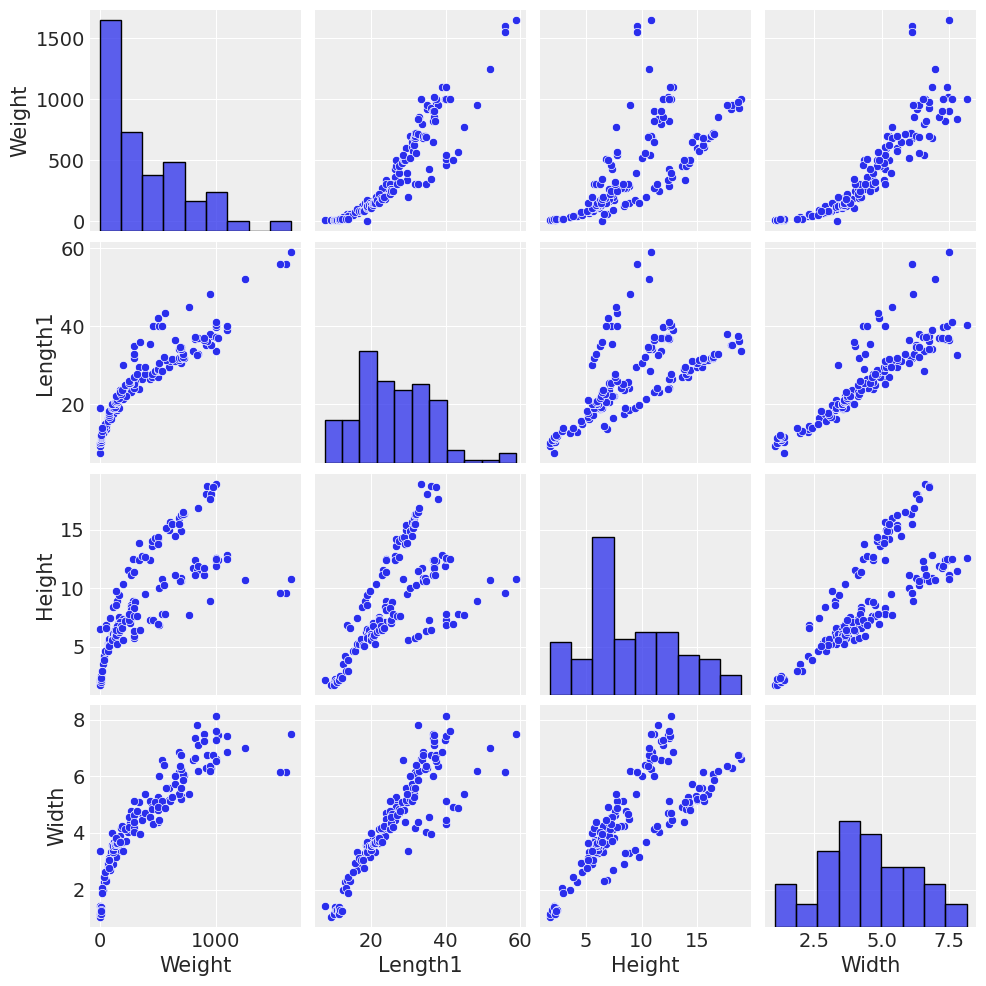

In [8]:
sns.pairplot(data=fish_market);

All variables evolve linearly with each other, except for weight, which seems to increase exponentially with the other variables -- well, up to a point, because there is a natural upper bound to the weight. 

We also notice several trends in the data -- it's very probably just the differences between species:

/Users/alex_andorra/opt/anaconda3/envs/intuitive_bayes/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


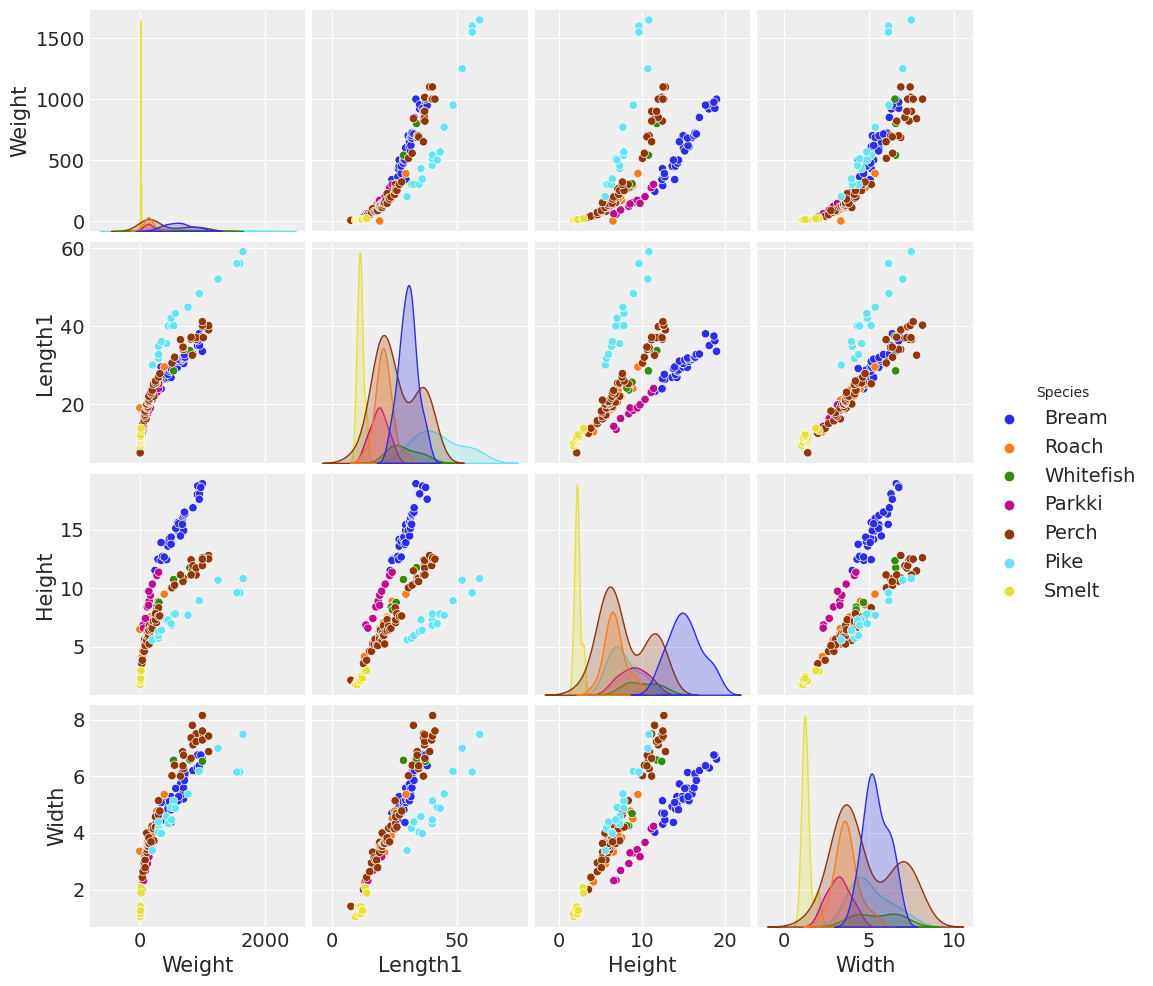

In [9]:
sns.pairplot(data=fish_market, hue="Species");

Indeed, the different species behave differently, which is unsurprising.

To conclude our exploration of the data, let's look at a violin plot. It could give us useful hints about each species:

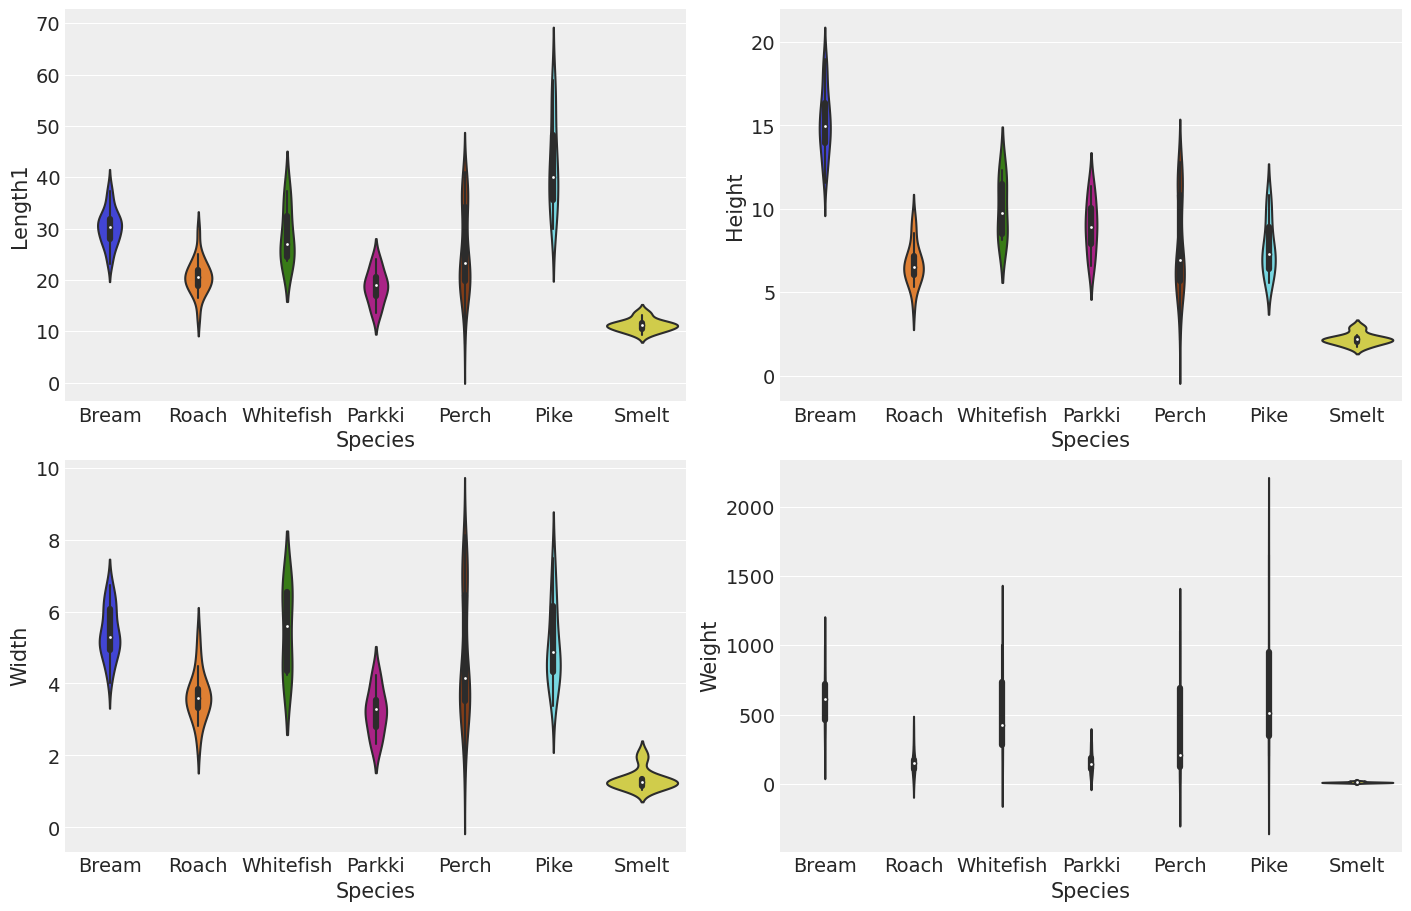

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
for ax, var in zip(axes.ravel(), ["Length1", "Height", "Width", "Weight"]):
    sns.violinplot(x="Species", y=var, data=fish_market, ax=ax)

The most diverse species are Bream, Whitefish, Perch and Pike, which means they are probably easier to sell and cook, as they exist in a variety of weight, width and height. Conversely, the Smelt is a very small fish that is probably used only in specialized recipes -- a quick internet search will show you that they are usually fried and served as appetizers, at least in Europe.

---

*Hungry? Our in-house Asian food expert, Thomas Wiecki, recommends you to watch [_Jiro Dreams of Sushi_](https://www.imdb.com/title/tt1772925/), as documentary on 85-year-old sushi master Jiro Ono 😋*

---

### Section recap

- Visual exploration is crucial to understand how the variables relate to one another
- It completes your understanding of the data generating process
- It gives you hints for modeling
- It's a step of the workflow where consulting domain experts is very helpful

## A non-Bayesian linear regression

Now that we have a better idea of the data we're dealing with, let's start thinking about a model. Let's say that our task is to **predict the weight of a fish given his width, height and length** -- of course, we could choose any permutation of independent and dependent variables here.

The most promising approach is probably to try and come up with a physical model: height, width and weight are related to each other through physical proportions that naturally induce lower and upper bounds. If we were to use this model for professional purposes, that would be our best bet.

But this is more intricate, so here we can make a first try with the good ol' linear regression, our very versatile statistical friend.

As we saw however, weight is not linearly related to the other variables. So, as often, we need to apply some transformation to the data. What about a log transform? This looks like a natural choice to counteract the exponential increase in weight as other variables increase.

In [11]:
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)

/Users/alex_andorra/opt/anaconda3/envs/intuitive_bayes/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


What's that weird "divide by zero" warning Pandas is raising? 

Actually, we have observations with weight zero, remember? So, when we took the log above, Pandas threw us a warning, because the logarithm of zero is -inf. Now is a good time to do something about this, and the easiest is just to get rid of these observations (aka a complete case analysis)

Careful though: this is in itself an assumption, as it assumes that the missing values aren't systematically different from the non-missing values -- you can see why this would be a problem sometimes.

In [12]:
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()

A simple way to check that our transformation worked is to call Seaborn's `lmplot` function, which plots the data and fits a simple OLS regression model over categories of a dataset:

/Users/alex_andorra/opt/anaconda3/envs/intuitive_bayes/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


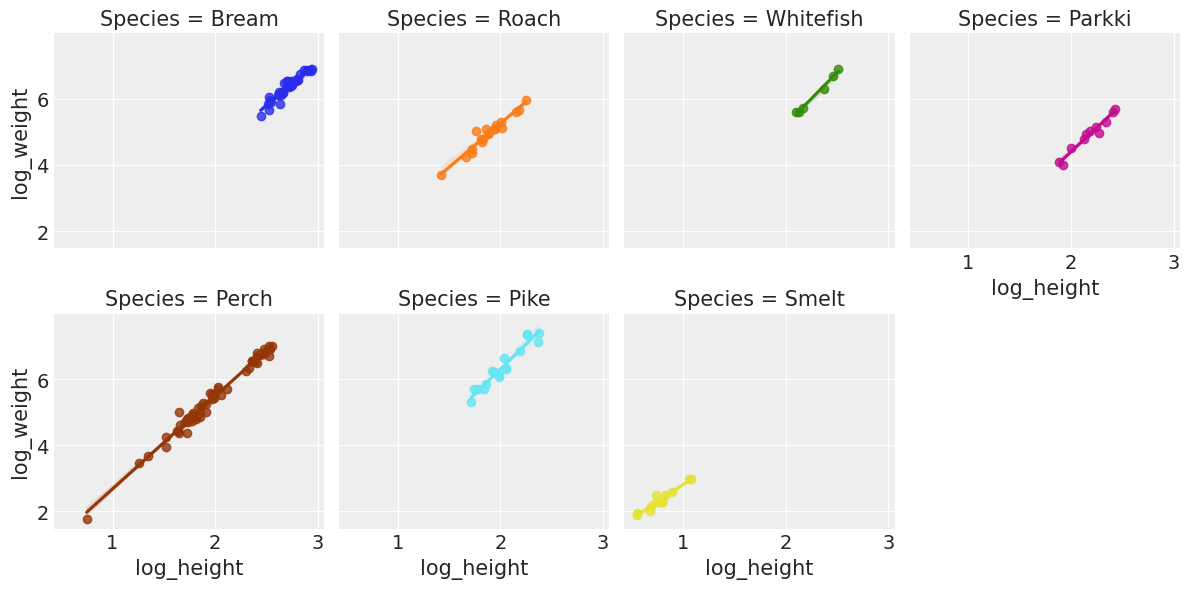

In [13]:
sns.lmplot(
    data=fish_reduced,
    x="log_height",
    y="log_weight",
    hue="Species",
    col="Species",
    height=3,
    col_wrap=4,
);

Did you notice what we just did? We ran a model! More precisely, a linear regression with flat priors and a Normal likelihood. That's what `sns.lmplot` (and countless statistical software) does under the hood. If you remember it's a model and it has assumptions, it's ok. The problem can arise when you forget it's actually a model and not just a plot or a line of code...

This is not our final model, but that's a good indication that our transformation worked: in log space, our data are indeed linearly related. Do you hear that sound? That's people cheering because now we can safely use linear regression!

It's time to code up this bad boy in PyMC!

### Section recap

- Scaling variables (log, exp, z-score, etc.) is very common in statistics and can be very important for modeling
- Throwing away missing data or outliers is a strong assumption -- i.e the missing values aren't systematically different from the non-missing values
- A simple OLS regression is already a model: it's a linear regression with flat priors and a Normal likelihood
- Remember that when using blackbox software

## A simple PyMC model

Let's start with a very simple model: a linear regression with just an intercept, no covariates.

$$log(weight) \sim Normal(intercept, sigma)$$
$$intercept \sim Normal(0, 1)$$
$$sigma \sim HalfNormal(1)$$

In [14]:
with pm.Model(rng_seeder=RANDOM_SEED) as fish_simple:
    intercept = pm.Normal("intercept")
    sigma = pm.HalfNormal("sigma", 1.0)

    pm.Normal(
        "log_weight",
        mu=intercept,
        sigma=sigma,
        observed=fish_reduced.log_weight.values,
    )

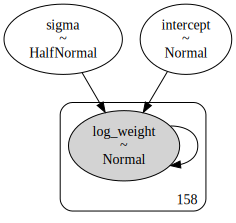

In [15]:
pm.model_to_graphviz(fish_simple)

Everything is ready for sampling. You know the drill now: always sample the forward distributions (i.e prior predictive and posterior predictive):

In [16]:
with fish_simple:
    idata_simple = pm.sample()
    idata_simple.extend(pm.sample_prior_predictive())
    idata_simple.extend(pm.sample_posterior_predictive(idata_simple))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [17]:
arviz.summary(idata_simple, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.35,0.10,5.16,5.54,0.0,0.0,3156.68,2815.34,1.0
sigma,1.33,0.08,1.18,1.46,0.0,0.0,2950.51,2533.49,1.0


Apart from showing us that sampling went well (R_hat values and effective sample sizes look good), this summary isn't very actionable -- this model is very simple, so the mean coefficient estimates are basically the mean and standard deviation of the data respectively. 

As a rule of thumb though, parameter estimates are really hard to read from a summary table, so I tend to rely on other functions to understand my models' results. Trace plots are particularly useful:

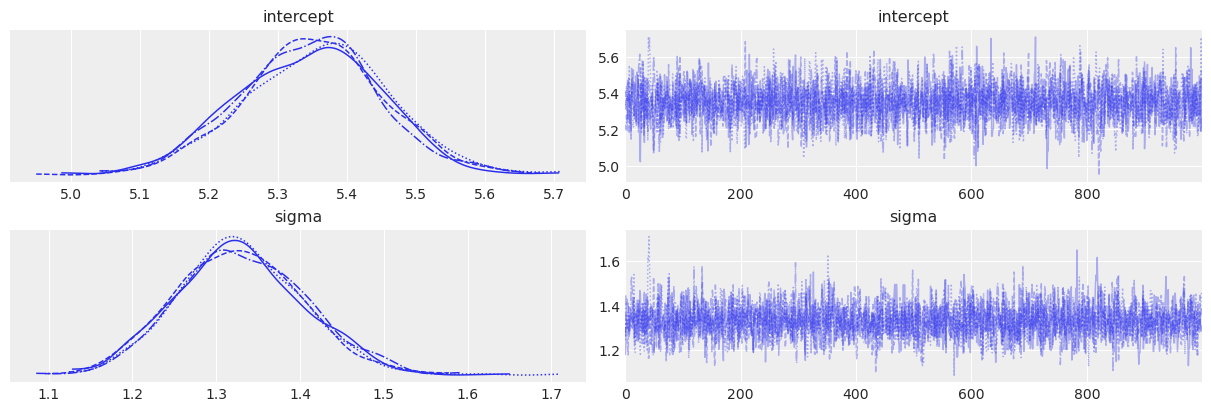

In [18]:
arviz.plot_trace(idata_simple);

Our posterior uncertainty doesn't seem big. But remember that we're on log scale, so that would be best to get back to the outcome scale. We just have to exponentiate, and ArviZ even has a nice `transform` kwarg to do so:

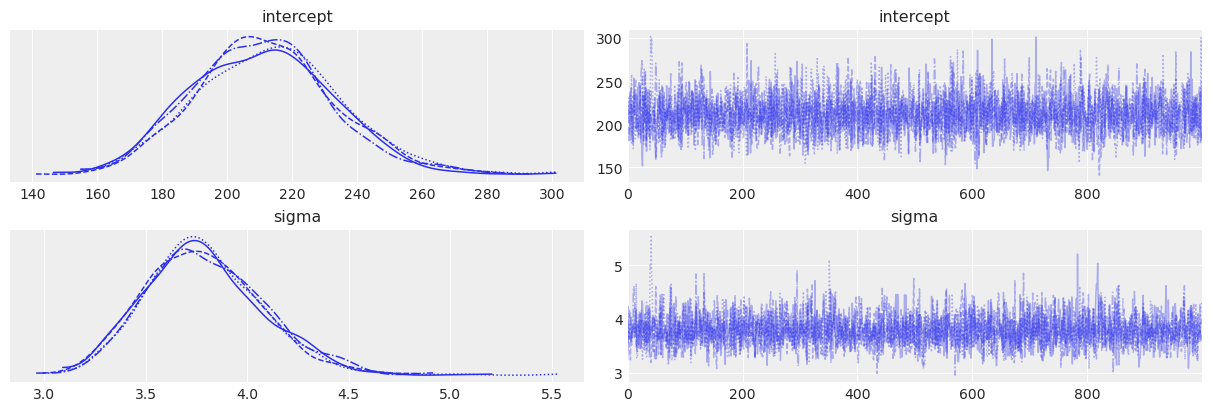

In [19]:
arviz.plot_trace(idata_simple, transform=np.exp);

The uncertainty is high actually! Well, as my good friend Nicole would say, "what did you expect?", this is a trivial model. And we didn't put any effort into our choice of prior, as ArviZ is keen to show us:

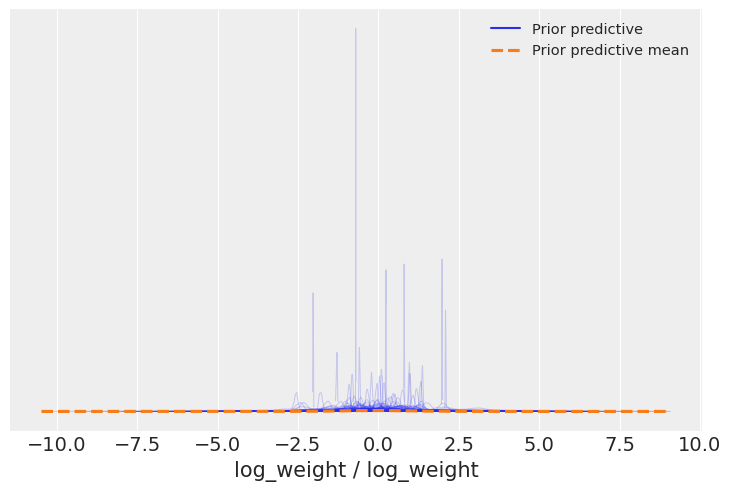

In [20]:
arviz.plot_ppc(idata_simple, group="prior", observed=False);

That's a bit too flat, don't you think? Let's see what our posterior predictions look like:

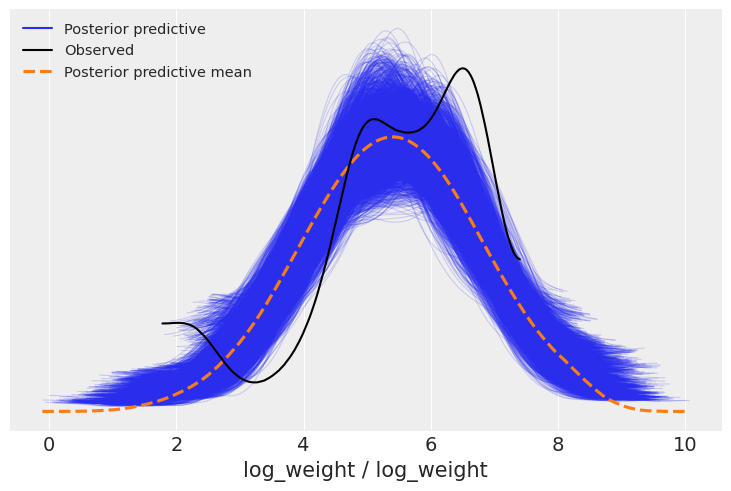

In [21]:
arviz.plot_ppc(idata_simple);

Well that's not good... There are clearly several populations in these data, and our model is unable to pick them up. That's probably why it needs a large posterior uncertainty and observational noise (`sigma`) -- that way, it can encompass everything.

### Section recap

- Always start with the simplest possible model -- just an intercept, no covariates
- `pm.model_to_graphviz` is very useful to understand and debug your model
- Always sample the forward distributions and do prior / posterior predictive checks to understand your model
- Remember to convert the estimates on the outcome scale if you transformed the data before fitting the model

## Adding predictors to our model

This time, we'll add predictors to our regression, namely the width, height, and length of each fish -- this should further help improve our predictions and decrease our posterior uncertainty.

But let's think a bit more about it: where could the different populations come from? Probably from the different species. So we should also allow our model to behave differently for each species. Can you guess how it's called? Yep, it's an unpooled model, where we basically fit as many different regressions as there are species.

So that means that each species gets its own intercept and slopes. We'll also need to map each observation in our dataset to the species it belongs to. Here is a very convenient way to do so:

In [22]:
fish_reduced.Species.factorize(sort=True)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5]),
 Index(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'], dtype='object'))

Pandas automatically associates each species with a number, and then maps each row in the data to the corresponding species. We can then use this directly in our PyMC model, thanks to... dimensions and coordinates, as we saw in the Tools lesson!

What are our dimensions here? As we alluded to, there are two: `slopes` and `species`. Now, what are the coordinates of those dimensions? Well, we have 3 slopes (width, height and length) and 7 species (the ones Pandas isolated for us above).

Now we just have to define these dimensions and coordinates in a dictionary:

In [23]:
species_idx, species = fish_reduced.Species.factorize(sort=True)
COORDS = {
    "slopes": ["width_effect", "height_effect", "length_effect"],
    "species": species,
}

And then we pass it to the `coords` kwarg of `pm.Model`. In addition, instead of specifying the shape of our intercept and slopes, we only have to tell PyMC about the dimensions they are associated with (here, either `slopes`, `species` or both).

Lastly, we'll declare the data we need for this model in a `Data` container. This is mainly a way to make the model aware of the data we have, which means we'll be able to change the data on the fly when doing predictions later on. For more details about the `Data` container and the definition of `dims` and `coords`, take a look at this [quick tutorial](https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/data_container.html).

In [24]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_unpooled:
    # data
    log_width = pm.Data("log_width", fish_reduced.log_width.values)
    log_height = pm.Data("log_height", fish_reduced.log_height.values)
    log_length = pm.Data("log_length", fish_reduced.log_length.values)
    log_weight = pm.Data("log_weight", fish_reduced.log_weight.values)
    species_idx_ = pm.Data("species_idx", species_idx)

    # priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("slopes", "species"))

    # linear regression
    mu = (
        intercept[species_idx]
        + β[0, species_idx_] * log_width
        + β[1, species_idx_] * log_height
        + β[2, species_idx_] * log_length
    )
    # observational noise
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood
    pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

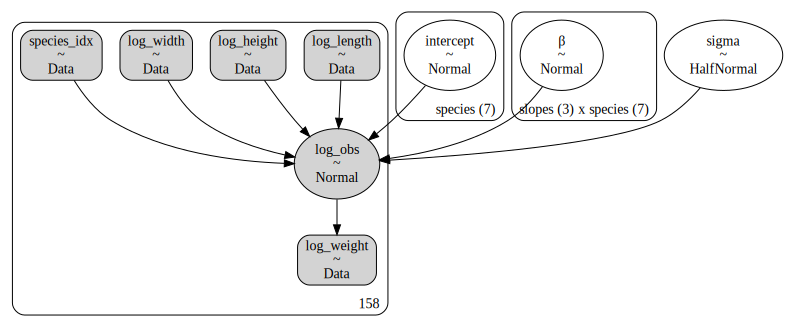

In [25]:
pm.model_to_graphviz(fish_unpooled)

In [26]:
with fish_unpooled:
    idata_unpooled = pm.sample()
    idata_unpooled.extend(pm.sample_prior_predictive())
    idata_unpooled.extend(pm.sample_posterior_predictive(idata_unpooled))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 126 seconds.


Sampling went really great: lightning fast and no warnings whatsoever. Now, how does our trace plot look like?

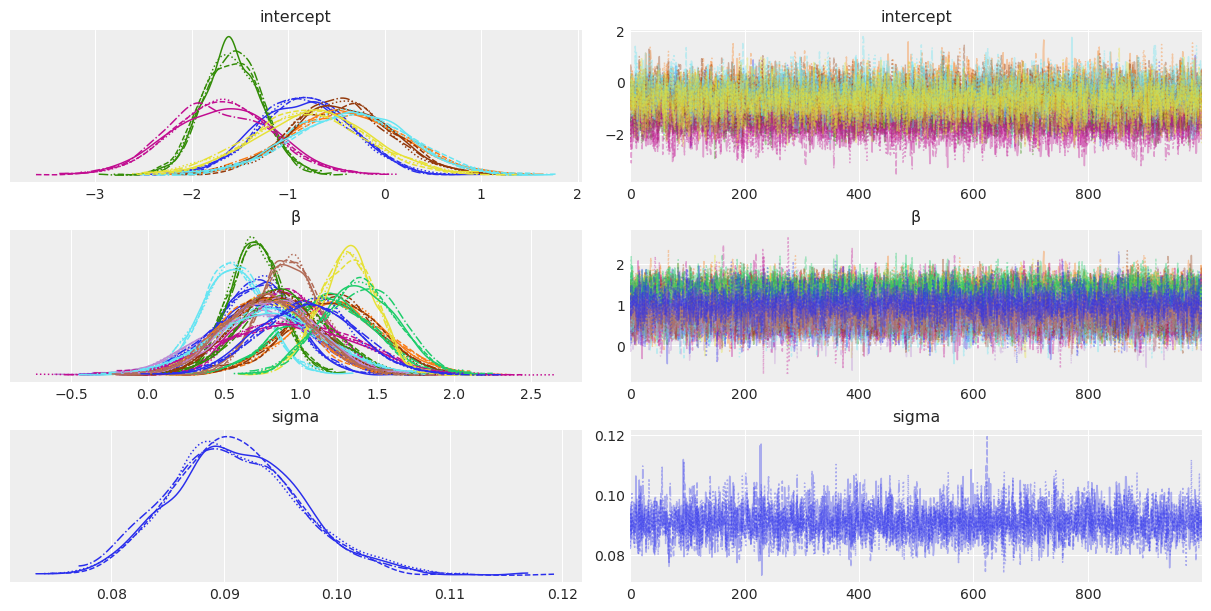

In [27]:
arviz.plot_trace(idata_unpooled);

There is a good sign here: the posterior uncertainty around `sigma` is much lower than before, i.e we picked up much more information on the fish weights. But did this improve our posterior predictions?

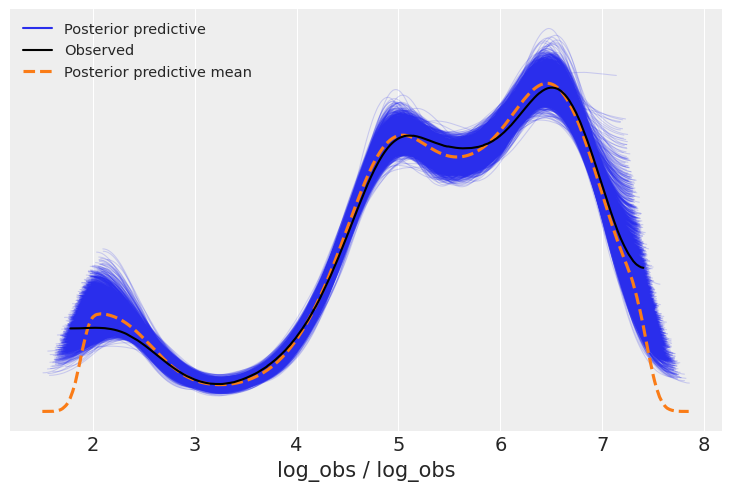

In [28]:
arviz.plot_ppc(idata_unpooled);

Well that's much better! Our model is now able to pick up the differences between species. And we could do even better: again, we didn't think seriously about out priors:

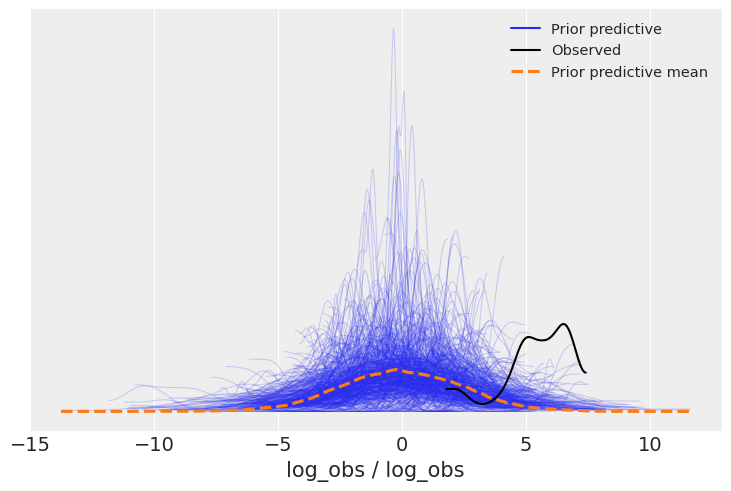

In [29]:
arviz.plot_ppc(idata_unpooled, group="prior");

Doesn't look too good. Actually, do you have an idea how we could make these priors more informative? The principles are the same as those we outlined in the previous lessons, so we'll let you do that as an exercise. While you're at it, try to build the completely pooled version of this model (i.e a big regression for all the species, with the same predictors). Do you expect it to fare better or worse than this last model?

### Section recap

- Adding predictors will, by definition, decrease the uncertainty in the model's prediction
- Understanding the data (species behave differently) is what helped us most here
- `dims` and `coords` make it much easier to define unpooled (i.e parallelized) models
- `pm.Data` makes the model data-aware and helps for out-of-sample predictions

## Predicting out-of-sample

A common use case in a statistical workflow is to make predictions with new, unobserved data, which are poetically called "out-of-sample" data. To do that in PyMC, the easiest is to use the `Data` container, which makes PyMC and ArviZ aware of the data the model was trained on, which means you'll be able to change them later on. 

To demonstrate this functionality, let's randomly take out 10% of our dataset, use the remaining 90% as the training dataset for the model, and use the 10% as test data (i.e the model will never see them before doing predictions):

In [30]:
fish_test = fish_reduced.sample(frac=0.1, random_state=RANDOM_SEED).sort_index()
test_idx = fish_test.index
fish_train = fish_reduced.loc[fish_reduced.index.difference(test_idx)]

The dataset changed compared to the previous model, so we have to redefine our coordinates:

In [31]:
species_idx, species = fish_train.Species.factorize(sort=True)
COORDS["species"] = species

Other than that, the model is _exactly_ the same as before:

In [32]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_unpooled_oos:
    # data
    log_width = pm.Data("log_width", fish_train.log_width.values)
    log_height = pm.Data("log_height", fish_train.log_height.values)
    log_length = pm.Data("log_length", fish_train.log_length.values)
    log_weight = pm.Data("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.Data("species_idx", species_idx)

    # priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("slopes", "species"))

    # linear regression
    mu = (
        intercept[species_idx_]
        + β[0, species_idx_] * log_width
        + β[1, species_idx_] * log_height
        + β[2, species_idx_] * log_length
    )
    # observational noise
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

    # sampling
    idata_unpooled_oos = pm.sample()
    idata_unpooled_oos.extend(pm.sample_prior_predictive())
    idata_unpooled_oos.extend(pm.sample_posterior_predictive(idata_unpooled_oos))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.


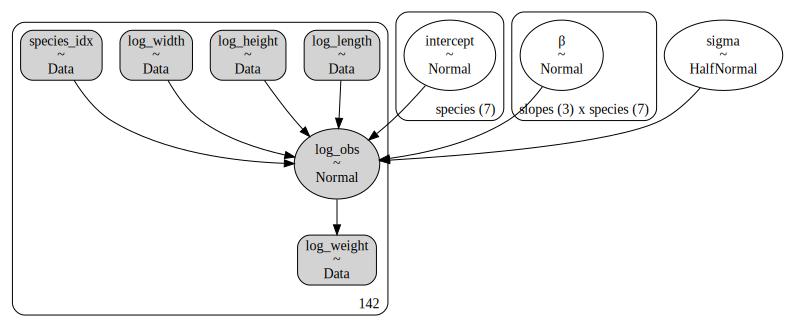

In [33]:
pm.model_to_graphviz(fish_unpooled_oos)

Again, sampling was smooth, and the trace plot looks great:

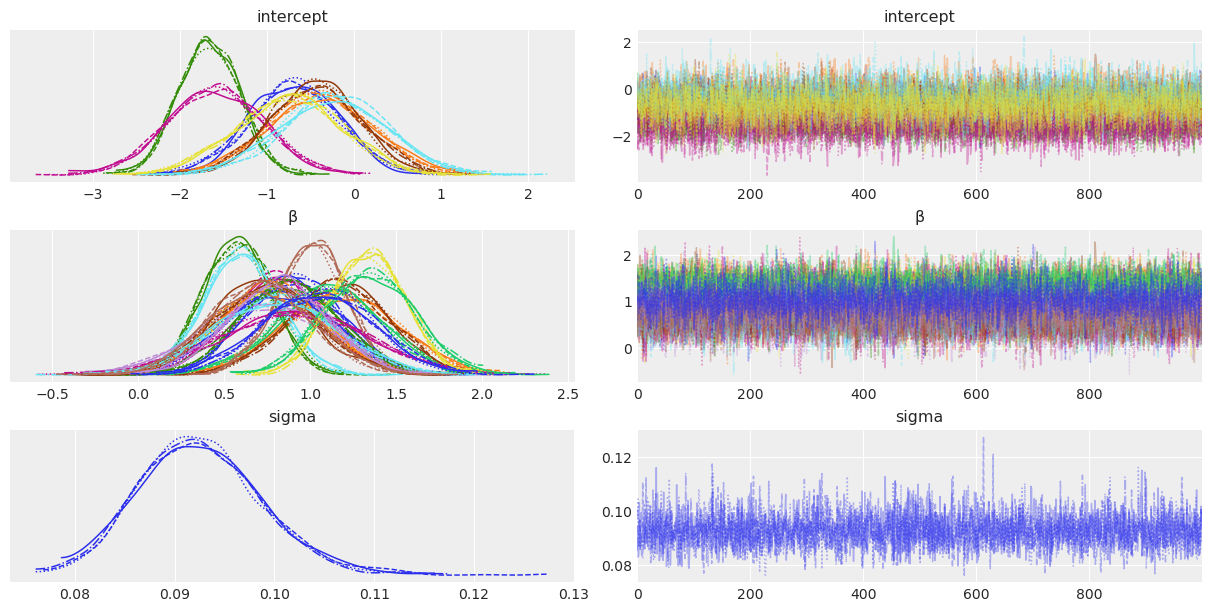

In [34]:
arviz.plot_trace(idata_unpooled_oos);

Now, let's imagine our colleagues come to use with new data. They want to know what the model's predictions are, based on these new data and the inferences we made on the training dataset. As a reminder, here are the new data:

In [40]:
fish_test

,Species,Weight,Length1,Height,Width,log_width,log_height,log_length,log_weight
12,Bream,500.0,29.1,13.7592,4.3680,1.474305,2.621708,3.370738,6.214608
20,Bream,575.0,31.3,15.1285,5.5695,1.717305,2.716580,3.443618,6.354370
26,Bream,720.0,32.0,16.3618,6.0900,1.806648,2.794949,3.465736,6.579251
34,Bream,950.0,38.0,17.6235,6.3705,1.851678,2.869233,3.637586,6.856462
38,Roach,87.0,18.2,5.6166,3.1746,1.155182,1.725726,2.901422,4.465908
48,Roach,169.0,22.0,7.5344,3.8352,1.344222,2.019479,3.091042,5.129899
65,Parkki,150.0,18.4,8.8928,3.2928,1.191738,2.185242,2.912351,5.010635
71,Parkki,300.0,24.0,11.3680,4.2340,1.443147,2.430802,3.178054,5.703782
79,Perch,80.0,17.2,5.6358,3.0502,1.115207,1.729139,2.844909,4.382027
84,Perch,125.0,19.0,5.6925,3.6675,1.299510,1.739150,2.944439,4.828314


So, we need to give the model the new values of `log_width`, `log_height`, `log_length` and `Species`, and see what it predicts as `log_weight`. Here is how you tell PyMC to do just that:

In [ ]:
with fish_unpooled_oos:
    # update values of predictors:
    pm.set_data(
        {
            "log_height": fish_test.log_height.values,
            "log_length": fish_test.log_length.values,
            "log_width": fish_test.log_width.values,
            "species_idx": fish_test.Species.factorize(sort=True)[0],
        }
    )

Once that's done, we can just call `sample_posterior_predictive`. The only difference is that we're telling PyMC these are really predictions (`predictions=True`), and we want them appended to our existing `InferenceData` object (`extend_inferencedata=True`).

In [35]:
with fish_unpooled_oos:
    # use the updated values to predict outcomes:
    idata_unpooled_oos = pm.sample_posterior_predictive(
        idata_unpooled_oos,
        predictions=True,
        extend_inferencedata=True,  # not released yet, needs main branch
    )

In [37]:
idata_unpooled_oos

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> predictions_constant_data

How good are these imputations? Glad you asked. Remember that our data are not _really_ out-of-sample; we just cut them out from our original dataset, so we can compare our predictions to the true weights. This is a simple line of code in ArviZ (we just exponentiate the predicted log weights to compare them to the true weights):

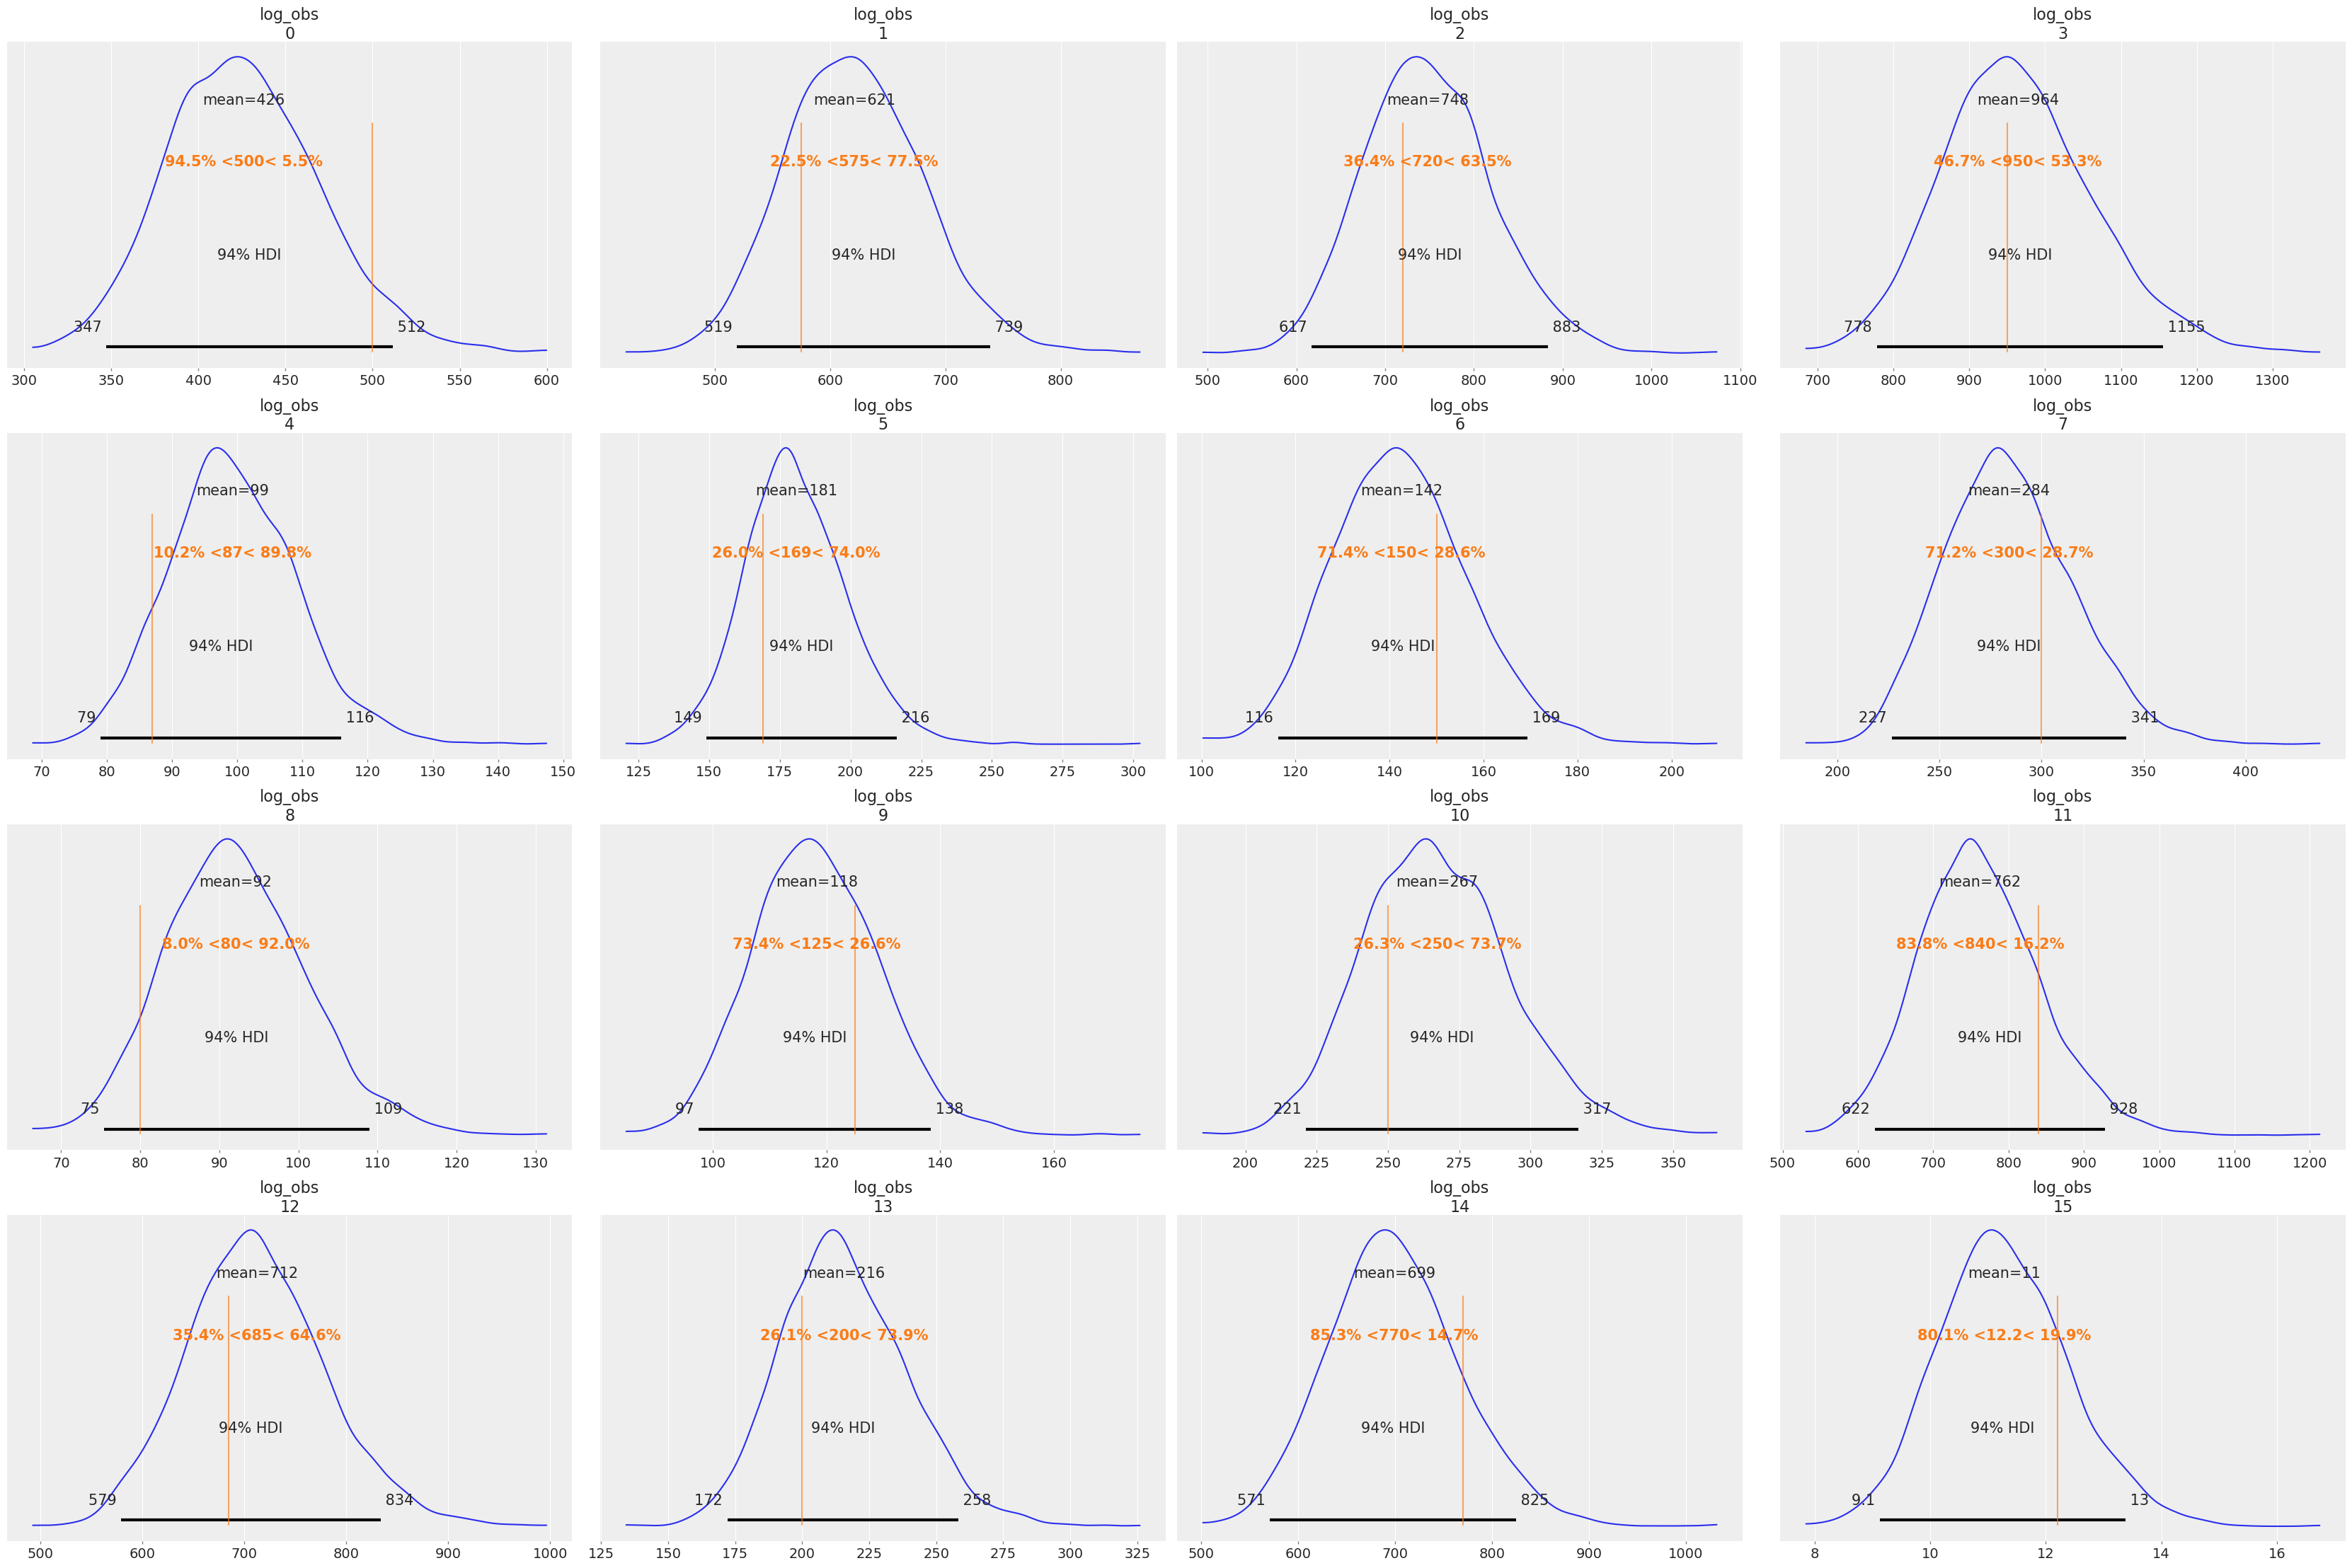

In [38]:
arviz.plot_posterior(
    idata_unpooled_oos.predictions,
    ref_val=fish_test["Weight"].tolist(),
    transform=np.exp,
);

Look at that beauty! The model did an excellent job predicting those new weights: the true value is inside the inferred posterior distribution for _every_ new data point, without extremely small probabilities.

Stop, look at the time! It's time to go back to your colleagues with those results, remind them that beer is on them, and tell them about how awesome Bayes is around that beer 🍻

### Section recap

- Use `pm.set_data` to update the values of predictors
- `pm.sample_posterior_predictive(predictions=True, extend_inferencedata=True)` uses the updated values to predict outcomes and appends them to the original `InferenceData` object
- `az.plot_posterior` is 

## Lesson recap

- Linear regression is a very versatile kind of models.
- Transforming the data can make a big difference for model fitting (here we used a log transformation), but remember to transform the parameters back for easier interpretation of the model's output.
- NUTS cries loudly when it has difficulties exploring the posterior space, which forces the modeler to pay attention to the problems in their models.
- PyMC3 helps you focus on model building and improvement without specialized knowledge about fitting algorithms.
- ArviZ is your friend for all pre- and post-processing modeling steps.
- PyMC3 usually does a good job of automatically imputing missing data points for you. Keep in mind every imputation is an assumption though, which might demand more checks and caution.
- PyMC3's `Data` container is really useful to make the model data-aware, thus unlocking the possibility to make out-of sample predictions.